## Analze the data to find any trends

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"
# clsSDB = db.dataWorkLoads(
#     desc=__desc__,
#     db_type = 'bigquery',
#     db_driver=None,
#     db_hostIP=None,
#     db_port = None,
#     db_name = None,
#     db_schema='combined_data_facebook_ads',
#     spark_partitions=None,
#     spark_format = 'bigquery',
#     spark_save_mode=None,
#     # spark_jar_dir = _jar,
# )
clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

2025-02-19 15:12:46.794737: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 15:12:47.356075: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 15:12:47.455300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739949167.567765  495512 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739949167.589725  495512 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 15:12:47.681228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load Data

In [3]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
    file_name="complete-60-accounts.csv",  # optional - name of the file to read
    file_type=None,  # optional - read all the files of same type
    **options,
)
print("Loaded %d rows" % sdf.count())

25/02/19 15:16:53 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/19 15:16:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/19 15:16:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

Loaded 61513 rows


## Currency Convert the Spend

In [4]:
### USE python currency-converter librabry with date
sdf = sdf.withColumn(
    "spend_usd",
    F.when(F.col('account_currency').isin('CAD'), F.col('spend') * 0.70)
     .when(F.col('account_currency').isin('EUR'), F.col('spend') * 1.05)
     .when(F.col('account_currency').isin('THB'), F.col('spend') * 0.03)
     .when(F.col('account_currency').isin('INR'), F.col('spend') * 0.012)
     .when(F.col('account_currency').isin('USD'), F.col('spend') * 1.00)
     .otherwise(F.col('spend') * 1.00)
)

# sdf.printSchema()

## Filtered Dataframe
* goal = OFFSITE_CONVERSIONS
* columns = spend_usd, CPC, CPM, CTR, ROAS,<br><tab><tab>click, impressions, frequency, reach
* column value >= mean + 2 x sigma (95 percentile)
* account_currency = USD (market segment)

In [5]:
_data_sdf= sdf.select('updated_time','spend_usd',
                     'CPC', 'CPM', 'CTR', 'ROAS', 
                     'impressions', 'click', 'reach', 'frequency')\
            .where(F.col('goal').isin('OFFSITE_CONVERSIONS') & \
                  F.col('account_currency').isin('USD'))\
            .dropna().orderBy('updated_time').toPandas()
print(_data_sdf.shape)
''' keep 95 percentile of the data '''
# for _col in _data_df.columns:
#     _data_df = _data_df[_data_df[_col]<=\
#                     _data_df[_col].mean()+2*_data_df[_col].std()]
# _data_df = _data_df.sample(n=1000)

print("data shape:", _data_sdf.shape)
print("some stats:\n", _data_sdf.describe())

(5410, 10)
data shape: (5410, 10)
some stats:
          spend_usd          CPC          CPM          CTR         ROAS  \
count  5410.000000  5410.000000  5410.000000  5410.000000  5410.000000   
mean    158.887595     1.534631    34.432724     4.241159    14.086828   
std     245.156925     1.420919    15.516359     4.185344   134.740147   
min       0.010000     0.000000     3.488372     0.000000     0.014839   
25%      28.982500     0.579047    23.617451     1.500617     1.454179   
50%      83.210000     1.191947    31.438177     2.793171     3.114280   
75%     208.467500     2.008000    41.878096     5.609371     7.089139   
max    5152.530000    19.015000   144.131274    39.328063  6859.000000   

         impressions         click          reach    frequency  
count    5410.000000   5410.000000    5410.000000  5410.000000  
mean     5394.156562    282.713494    4205.792237     1.307253  
std      9522.524528    756.059653    8090.816593     0.227749  
min         1.000000      

## Enrich data

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from Excel file
df = _data_sdf
df['updated_time']=pd.to_datetime(df['updated_time'])
df['day_of_week']=df['updated_time'].dt.day_name().astype('string')
df['month']=df['updated_time'].dt.month_name().astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   updated_time  5410 non-null   datetime64[ns]
 1   spend_usd     5410 non-null   float64       
 2   CPC           5410 non-null   float64       
 3   CPM           5410 non-null   float64       
 4   CTR           5410 non-null   float64       
 5   ROAS          5410 non-null   float64       
 6   impressions   5410 non-null   int32         
 7   click         5410 non-null   int32         
 8   reach         5410 non-null   int32         
 9   frequency     5410 non-null   float64       
 10  day_of_week   5410 non-null   string        
 11  month         5410 non-null   string        
dtypes: datetime64[ns](1), float64(6), int32(3), string(2)
memory usage: 443.9 KB


In [8]:
df.corr()

,spend_usd,CPC,CPM,CTR,ROAS,impressions,click,reach,frequency
spend_usd,1.000000,-0.067739,0.047496,0.101493,-0.053341,0.881171,0.574280,0.871037,0.025638
CPC,-0.067739,1.000000,0.153694,-0.523274,-0.047904,-0.126011,-0.256054,-0.153577,0.314348
CPM,0.047496,0.153694,1.000000,0.107357,-0.059795,-0.181739,-0.166656,-0.162094,-0.242573
CTR,0.101493,-0.523274,0.107357,1.000000,-0.035905,0.135362,0.443172,0.177311,-0.432147
ROAS,-0.053341,-0.047904,-0.059795,-0.035905,1.000000,-0.046121,-0.031592,-0.042755,-0.038621
impressions,0.881171,-0.126011,-0.181739,0.135362,-0.046121,1.000000,0.791276,0.986593,0.047930
click,0.574280,-0.256054,-0.166656,0.443172,-0.031592,0.791276,1.000000,0.822762,-0.166403
reach,0.871037,-0.153577,-0.162094,0.177311,-0.042755,0.986593,0.822762,1.000000,-0.056384
frequency,0.025638,0.314348,-0.242573,-0.432147,-0.038621,0.047930,-0.166403,-0.056384,1.000000


In [9]:
from pycaret.regression import *

data = df[['updated_time', 'spend_usd', 'impressions', 'click', 'reach', 'frequency']]
s = setup(data, target='spend_usd', session_id = 123)
best = compare_models()
evaluate_model(best)
pre_holdout = predict_model(best)

new_df = data.copy().drop(['spend_usd'], axis=1)
predictions = predict_model(best, data=new_df)
save_model(best, 'best_pipeline')

,Description,Value
0,Session id,123
1,Target,spend_usd
2,Target type,Regression
3,Original data shape,"(5410, 6)"
4,Transformed data shape,"(5410, 8)"
5,Transformed train set shape,"(3786, 8)"
6,Transformed test set shape,"(1624, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,38.0837,8757.1572,88.7363,0.8508,0.3478,0.3273,0.5910
rf,Random Forest Regressor,39.1853,9763.0426,94.1469,0.8332,0.3490,0.3343,1.2120
lr,Linear Regression,50.3078,9089.0805,94.3769,0.8193,0.7960,3.1612,0.6660
ridge,Ridge Regression,50.3034,9088.7898,94.3756,0.8193,0.7961,3.1558,0.0420
lar,Least Angle Regression,50.3078,9089.0805,94.3769,0.8193,0.7960,3.1612,0.0480
lasso,Lasso Regression,50.4610,9123.5454,94.5820,0.8186,0.7987,2.8276,0.0470
llar,Lasso Least Angle Regression,50.4610,9123.5466,94.5820,0.8186,0.7987,2.8276,0.0510
en,Elastic Net,50.6612,9136.3898,94.6568,0.8184,0.8029,2.7627,0.0460
br,Bayesian Ridge,50.8081,9177.1697,94.8301,0.8180,0.8024,2.7210,0.0450
huber,Huber Regressor,47.0192,9231.8456,95.3309,0.8139,0.6091,1.3606,0.0850


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,39.5179,9597.1543,97.9651,0.8113,0.3378,0.3033


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['updated_time'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['impressions', 'click', 'reach',
                                              'frequency'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  ExtraTreesRegressor(n_jobs=-1, random_state=123))]),
 'best_pipeline.pkl')

<Axes: xlabel='dates'>

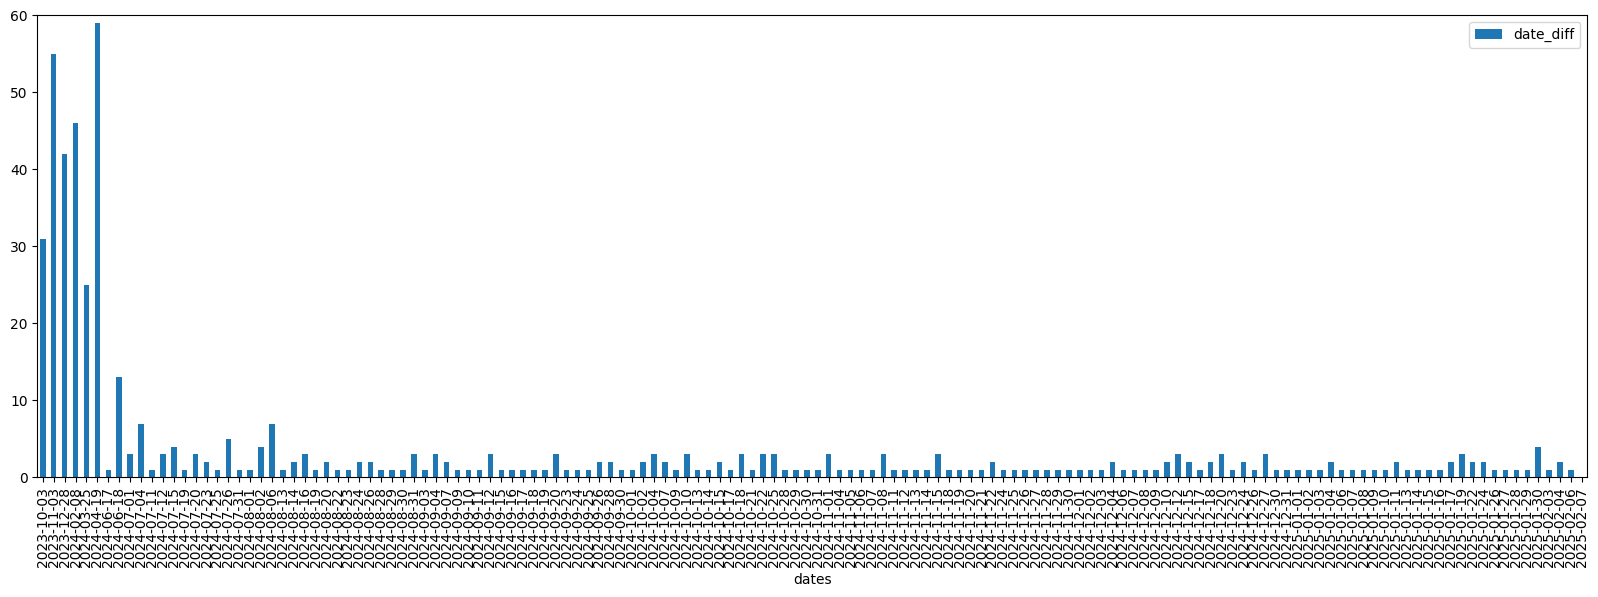

In [88]:
d_df.plot(x='dates',y='date_diff', kind='bar', figsize=(20,6), ylim=(0, 60))
# d_df.info()

In [76]:
dates_arr = _data_df.sort_values(by='updated_time', ascending=True)['updated_time'].unique()
d_df = pd.DataFrame(dates_arr, columns=['dates'])
d_df['dates_shift'] = d_df['dates'].shift(-1)
d_df['date_diff'] = (d_df['dates_shift'] - d_df['dates']) / pd.Timedelta(days=1)
d_df['date_diff'].describe()

count    141.000000
mean       3.496454
std        8.841965
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       59.000000
Name: date_diff, dtype: float64

<Axes: xlabel='updated_time'>

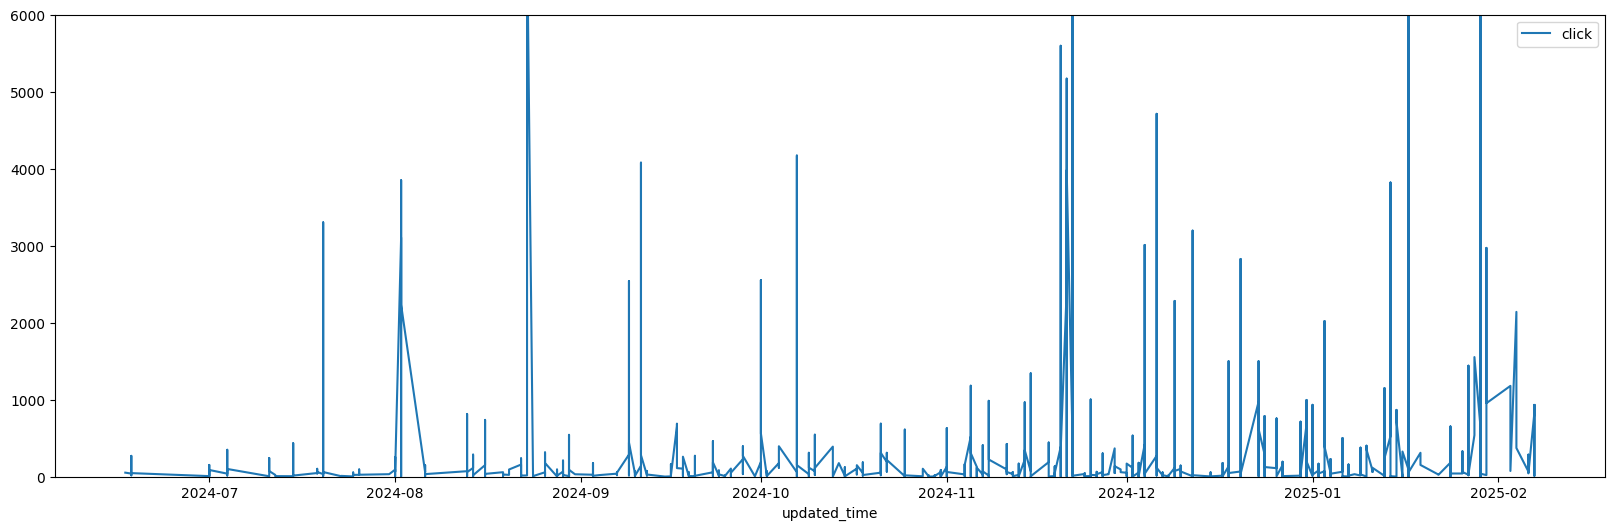

In [90]:
from datetime import date

df=_data_df[_data_df['updated_time']>=date(2024,6,1)]
df.plot(x='updated_time', y='click', figsize=(20,6), ylim=(0, 6000))

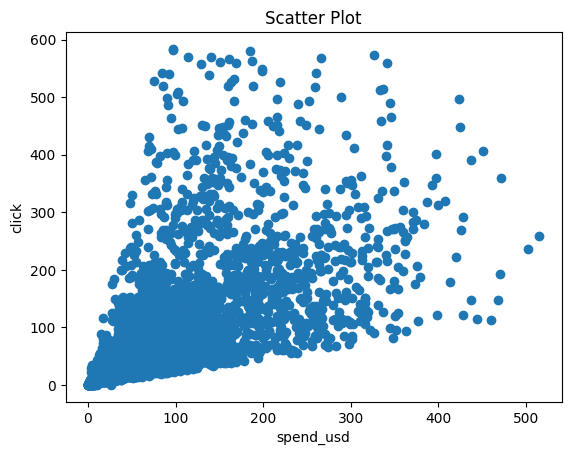

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

_x_col, _y_col = 'spend_usd', 'click' #, 'reach'
plt.scatter(_data_df[_x_col],_data_df[_y_col])
plt.title("Scatter Plot")
plt.xlabel(_x_col)
plt.ylabel(_y_col)
plt.show()

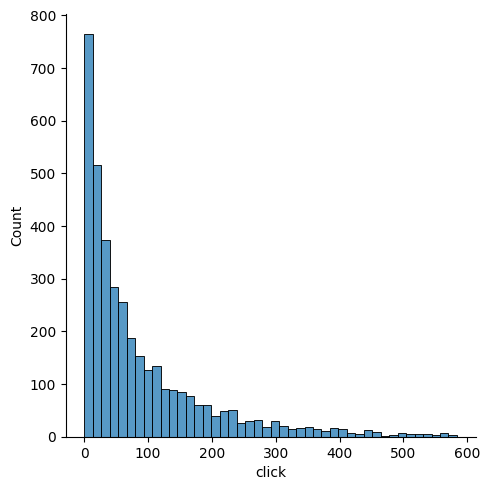

In [10]:
import seaborn as sns 

# sns.displot(_data_df, x=_x_col)
sns.displot(_data_df, x=_y_col)

<Axes: xlabel='updated_time'>

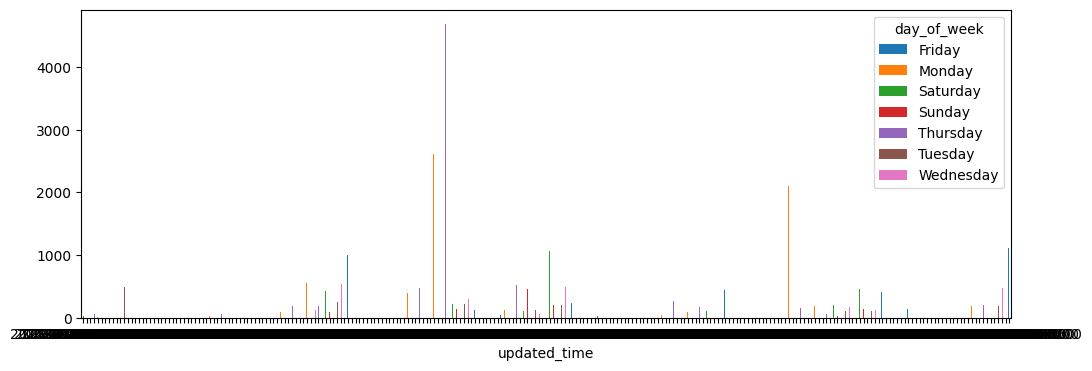

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_df = dow_df.pivot(index="updated_time", 
                       columns="day_of_week", values="click_sum")

fig, axs = plt.subplots(figsize=(12, 4))

plot_df.plot(kind='bar', rot=0, ax=axs)